In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import multivariate_normal

In [2]:
np.random.seed(42)

train_data = np.loadtxt('hwk3data\hwk3data\EMGaussian.train')

test_data = np.loadtxt('hwk3data\hwk3data\EMGaussian.test')

data = train_data
n_clusters = 4
n_iter = 50

In [3]:
def covariance(x):
    x_mu = np.mean(x,axis=0)
    
    cov = np.zeros((x.shape[1],x.shape[1]))
    for i in range(x.shape[0]):
        cov += np.outer((x[i,:] - x_mu),(x[i,:] - x_mu))
    cov = cov*1.0/x.shape[0]
    return cov

def weighted_covariance(x, x_mu, tau):
    cov = np.zeros((x.shape[1],x.shape[1]))
    for i in range(x.shape[0]):
        cov += tau[i]*np.outer((x[i,:] - x_mu),(x[i,:] - x_mu))
    cov = cov*1.0/np.sum(tau)
    return cov

In [4]:
def plot_ellipse(semimaj=1,semimin=1,phi=0,x_cent=0,y_cent=0,theta_num=1e3,ax=None,plot_kwargs=None,\
                    fill=False,fill_kwargs=None,data_out=False,cov=None,mass_level=0.68,colour='b',label=''):
   
    # Get Ellipse Properties from cov matrix
    if cov is not None:
        eig_vec,eig_val,u = np.linalg.svd(cov)
        # Make sure 0th eigenvector has positive x-coordinate
        if eig_vec[0][0] < 0:
            eig_vec[0] *= -1
        semimaj = np.sqrt(eig_val[0])
        semimin = np.sqrt(eig_val[1])
        if mass_level is None:
            multiplier = np.sqrt(2.279)
        else:
            distances = np.linspace(0,20,20001)
            chi2_cdf = chi2.cdf(distances,df=2)
            multiplier = np.sqrt(distances[np.where(np.abs(chi2_cdf-mass_level)==np.abs(chi2_cdf-mass_level).min())[0][0]])
        semimaj *= multiplier
        semimin *= multiplier
        phi = np.arccos(np.dot(eig_vec[0],np.array([1,0])))
        if eig_vec[0][1] < 0 and phi > 0:
            phi *= -1

    # Generate data for ellipse structure
    theta = np.linspace(0,2*np.pi,theta_num)
    r = 1 / np.sqrt((np.cos(theta))**2 + (np.sin(theta))**2)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    data = np.array([x,y])
    S = np.array([[semimaj,0],[0,semimin]])
    R = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
    T = np.dot(R,S)
    data = np.dot(T,data)
    data[0] += x_cent
    data[1] += y_cent

    # Output data?
    if data_out == True:
        return data

    # Plot!
    return_fig = False
    if ax is None:
        return_fig = True
        fig,ax = plt.subplots()

    if plot_kwargs is None:
        ax.plot(data[0],data[1],color=colour,label=label,linestyle='-')
    else:
        ax.plot(data[0],data[1],color=colour,label=label,**plot_kwargs)

    if fill == True:
        ax.fill(data[0],data[1],**fill_kwargs)

    if return_fig == True:
        return fig

def plot_ellipse_cov(cov, cent, ax, colour='b',label=''):
    w,v = np.linalg.eig(cov)
    semi_major_axis_len = 2*np.sqrt(4.6*w[0])
    semi_minor_axis_len = 2*np.sqrt(4.6*w[1])
    theta = np.arctan(v[1,0]/v[0,0])
    plot_ellipse(semi_major_axis_len, semi_minor_axis_len, theta, cent[0], cent[1], ax=ax, colour=colour,label=label)
    

In [5]:
def compute_NLL(data, mu_list, sigma_list, pi_list):
    nll = 0
    mu_0 = mu_list[0]
    mu_1 = mu_list[1]
    mu_2 = mu_list[2]
    mu_3 = mu_list[3]
    
    sigma_0 = sigma_list[0]
    sigma_1 = sigma_list[1]
    sigma_2 = sigma_list[2]
    sigma_3 = sigma_list[3]
    
    pi_0 = pi_list[0]
    pi_1 = pi_list[1]
    pi_2 = pi_list[2]
    pi_3 = pi_list[3]
    
    for i in range(data.shape[0]):
        x = pi_0*multivariate_normal.pdf(data[i,:],mean=mu_0,cov=sigma_0) + pi_1*multivariate_normal.pdf(data[i,:],mean=mu_1,cov=sigma_1) + pi_2*multivariate_normal.pdf(data[i,:],mean=mu_2,cov=sigma_2) + pi_3*multivariate_normal.pdf(data[i,:],mean=mu_3,cov=sigma_3)
        nll += np.log(x)
    nll /= data.shape[0]
    
    return nll
   
def compute_k_means_loss(cluster_list, mu_list):
    loss = 0
    
    cluster_0 = cluster_list[0]
    cluster_1 = cluster_list[1]
    cluster_2 = cluster_list[2]
    cluster_3 = cluster_list[3]
    
    mu_0 = mu_list[0]
    mu_1 = mu_list[1]
    mu_2 = mu_list[2]
    mu_3 = mu_list[3]
    
    for i in range(cluster_0.shape[0]):
        loss += (np.linalg.norm(cluster_0[i,:] - mu_0.reshape(1,-1)))**2
        
    for i in range(cluster_1.shape[0]):
        loss += (np.linalg.norm(cluster_1[i,:] - mu_1.reshape(1,-1)))**2
        
    for i in range(cluster_2.shape[0]):
        loss += (np.linalg.norm(cluster_2[i,:] - mu_2.reshape(1,-1)))**2
        
    for i in range(cluster_3.shape[0]):
        loss += (np.linalg.norm(cluster_3[i,:] - mu_3.reshape(1,-1)))**2
        
    return loss

In [6]:
def k_means(data, n_clusters, n_iter):
    init_means_coord = np.zeros((n_clusters, 2))
    
    flag = True
    while(flag):
        init_means_coord[:,0] = np.random.uniform(np.min(data[:,0]),np.max(data[:,0]),size=(n_clusters))
        init_means_coord[:,1] = np.random.uniform(np.min(data[:,1]),np.max(data[:,1]),size=(n_clusters))
        
        labels = np.zeros((data.shape[0],1))
        for i in range(labels.shape[0]):
            dist = np.linalg.norm(np.tile(data[i,:],(n_clusters,1)) - init_means_coord, axis=1).reshape(-1,1)
            dist_argmax = np.argmax(dist, axis=0)
            labels[i,0] = dist_argmax[0]
        
        if len(np.unique(labels)) == n_clusters:
            flag = False
        
    for iter in range(n_iter):
        # E step
        for i in range(labels.shape[0]):
            dist = np.linalg.norm(np.tile(data[i,:],(n_clusters,1)) - init_means_coord, axis=1).reshape(-1,1)
            dist_argmin = np.argmin(dist, axis=0)
            labels[i,0] = dist_argmin[0]
           
        try:
            assert len(np.unique(labels)) == n_clusters
        except:
            non_present_labels = np.setdiff1d(np.arange(n_clusters),np.unique(labels)).tolist()
            labels_idx = np.random.choice(labels.shape[0],len(non_present_labels))
            for i,lbl in enumerate(non_present_labels):
                labels[labels_idx[i]] = lbl
            assert len(np.unique(labels)) == n_clusters
        # M step
        for i in range(n_clusters):
            init_means_coord[i,:] = np.mean(np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==i]),axis=0)
        
        if np.any(np.isnan(init_means_coord)):
            print 'ERROR!!!'
            break
    return labels

In [7]:
for trial in range(5):
    labels = k_means(data, n_clusters, n_iter)
    
    cluster_0 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==0]).reshape(-1,2)
    cluster_1 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==1]).reshape(-1,2)
    cluster_2 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==2]).reshape(-1,2)
    cluster_3 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==3]).reshape(-1,2)
    
    cluster_0_mu = np.mean(cluster_0,axis=0)
    cluster_1_mu = np.mean(cluster_1,axis=0)
    cluster_2_mu = np.mean(cluster_2,axis=0)
    cluster_3_mu = np.mean(cluster_3,axis=0)
    
    cluster_list = [cluster_0, cluster_1, cluster_2, cluster_3]
    mu_list = [cluster_0_mu, cluster_1_mu, cluster_2_mu, cluster_3_mu]
    k_means_loss = compute_k_means_loss(cluster_list, mu_list)
    
    print 'K-means Trial ID: %d loss = %f' % (trial, k_means_loss)
    print 'Cluster 0 co-ordinates:'
    print cluster_0_mu
    print '\n'
    print 'Cluster 1 co-ordinates:'
    print cluster_1_mu
    print '\n'
    print 'Cluster 2 co-ordinates:'
    print cluster_2_mu
    print '\n'
    print 'Cluster 3 co-ordinates:'
    print cluster_3_mu
    print '\n'

K-means Trial ID: 0 loss = 3240.593025
Cluster 0 co-ordinates:
[-3.6366214  -4.05302194]


Cluster 1 co-ordinates:
[ 3.78809286  4.99905357]


Cluster 2 co-ordinates:
[ 3.60401871 -2.88772669]


Cluster 3 co-ordinates:
[-2.1554649   4.11299388]


K-means Trial ID: 1 loss = 3237.779596
Cluster 0 co-ordinates:
[-3.81879354 -4.27423441]


Cluster 1 co-ordinates:
[ 3.80280826  5.10467248]


Cluster 2 co-ordinates:
[-2.24034752  4.12744772]


Cluster 3 co-ordinates:
[ 3.33557966 -2.644529  ]


K-means Trial ID: 2 loss = 3241.222949
Cluster 0 co-ordinates:
[ 3.47576567 -2.82062644]


Cluster 1 co-ordinates:
[-3.79520578 -4.24816219]


Cluster 2 co-ordinates:
[ 3.80007477  5.03387387]


Cluster 3 co-ordinates:
[-2.14180002  3.97338429]


K-means Trial ID: 3 loss = 3240.593025
Cluster 0 co-ordinates:
[-2.1554649   4.11299388]


Cluster 1 co-ordinates:
[-3.6366214  -4.05302194]


Cluster 2 co-ordinates:
[ 3.78809286  4.99905357]


Cluster 3 co-ordinates:
[ 3.60401871 -2.88772669]


K-means Tria

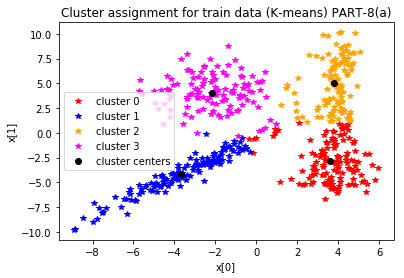

In [8]:
plt.plot(cluster_0[:,0], cluster_0[:,1], '*', c='red',label='cluster 0')
plt.plot(cluster_1[:,0], cluster_1[:,1], '*', c='blue',label='cluster 1')
plt.plot(cluster_2[:,0], cluster_2[:,1], '*', c='orange',label='cluster 2')
plt.plot(cluster_3[:,0], cluster_3[:,1], '*', c='magenta',label='cluster 3')

plt.plot(cluster_0_mu[0],cluster_0_mu[1],'o',c='black',label='cluster centers')
plt.plot(cluster_1_mu[0],cluster_1_mu[1],'o',c='black')
plt.plot(cluster_2_mu[0],cluster_2_mu[1],'o',c='black')
plt.plot(cluster_3_mu[0],cluster_3_mu[1],'o',c='black')
plt.legend()
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.title('Cluster assignment for train data (K-means) PART-8(a)')
plt.show()

In [9]:
# PART-B (EM with identity matrix as covariance)

cluster_0_mu = np.mean(cluster_0,axis=0)
cluster_1_mu = np.mean(cluster_1,axis=0)
cluster_2_mu = np.mean(cluster_2,axis=0)
cluster_3_mu = np.mean(cluster_3,axis=0)

cluster_0_sigma_2 = np.mean((np.linalg.norm(cluster_0 - cluster_0_mu.reshape(1,-1),axis=1))**2)/cluster_0_mu.shape[0]
cluster_1_sigma_2 = np.mean((np.linalg.norm(cluster_1 - cluster_1_mu.reshape(1,-1),axis=1))**2)/cluster_1_mu.shape[0]
cluster_2_sigma_2 = np.mean((np.linalg.norm(cluster_2 - cluster_2_mu.reshape(1,-1),axis=1))**2)/cluster_2_mu.shape[0]
cluster_3_sigma_2 = np.mean((np.linalg.norm(cluster_3 - cluster_3_mu.reshape(1,-1),axis=1))**2)/cluster_3_mu.shape[0]

pi_0 = cluster_0.shape[0]*1.0/labels.shape[0]
pi_1 = cluster_1.shape[0]*1.0/labels.shape[0]
pi_2 = cluster_2.shape[0]*1.0/labels.shape[0]
pi_3 = cluster_3.shape[0]*1.0/labels.shape[0]

tau = np.zeros((data.shape[0],n_clusters))
n_iter = 20

for iter in range(n_iter):
    # E step
    for i in range(tau.shape[0]):
        tau[i,0] = pi_0*multivariate_normal.pdf(data[i,:], mean=cluster_0_mu, cov=cluster_0_sigma_2*np.eye(cluster_0_mu.shape[0]))
        tau[i,1] = pi_1*multivariate_normal.pdf(data[i,:], mean=cluster_1_mu, cov=cluster_1_sigma_2*np.eye(cluster_1_mu.shape[0]))
        tau[i,2] = pi_2*multivariate_normal.pdf(data[i,:], mean=cluster_2_mu, cov=cluster_2_sigma_2*np.eye(cluster_2_mu.shape[0]))
        tau[i,3] = pi_3*multivariate_normal.pdf(data[i,:], mean=cluster_3_mu, cov=cluster_3_sigma_2*np.eye(cluster_3_mu.shape[0]))
        
        norm_factor = np.sum(tau[i,:])
        tau[i,0] = tau[i,0]/norm_factor
        tau[i,1] = tau[i,1]/norm_factor
        tau[i,2] = tau[i,2]/norm_factor
        tau[i,3] = tau[i,3]/norm_factor
        
    # M step
    cluster_0_mu = np.sum(data*tau[:,0].reshape(-1,1),axis=0)/np.sum(tau[:,0])
    cluster_1_mu = np.sum(data*tau[:,1].reshape(-1,1),axis=0)/np.sum(tau[:,1])
    cluster_2_mu = np.sum(data*tau[:,2].reshape(-1,1),axis=0)/np.sum(tau[:,2])
    cluster_3_mu = np.sum(data*tau[:,3].reshape(-1,1),axis=0)/np.sum(tau[:,3])
    
    cluster_0_sigma_2 = np.sum((np.linalg.norm((data - cluster_0_mu.reshape(1,-1)),axis=1)**2)*tau[:,0],axis=0)/(np.sum(tau[:,0])*cluster_0_mu.shape[0])
    cluster_1_sigma_2 = np.sum((np.linalg.norm((data - cluster_1_mu.reshape(1,-1)),axis=1)**2)*tau[:,1],axis=0)/(np.sum(tau[:,1])*cluster_1_mu.shape[0])
    cluster_2_sigma_2 = np.sum((np.linalg.norm((data - cluster_2_mu.reshape(1,-1)),axis=1)**2)*tau[:,2],axis=0)/(np.sum(tau[:,2])*cluster_2_mu.shape[0])
    cluster_3_sigma_2 = np.sum((np.linalg.norm((data - cluster_3_mu.reshape(1,-1)),axis=1)**2)*tau[:,3],axis=0)/(np.sum(tau[:,3])*cluster_3_mu.shape[0])
    
    pi_0 = np.sum(tau[:,0])/data.shape[0]
    pi_1 = np.sum(tau[:,1])/data.shape[0]
    pi_2 = np.sum(tau[:,2])/data.shape[0]
    pi_3 = np.sum(tau[:,3])/data.shape[0]

cluster_0 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==0]).reshape(-1,2)
cluster_1 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==1]).reshape(-1,2)
cluster_2 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==2]).reshape(-1,2)
cluster_3 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==3]).reshape(-1,2)

In [10]:
print 'mean vector for Gaussian ID: 0'
print cluster_0_mu
print 'covariance matrix for Gaussian ID: 0'
print cluster_0_sigma_2*np.eye(cluster_0.shape[1])
print 'mean vector for Gaussian ID: 1'
print cluster_1_mu
print 'covariance matrix for Gaussian ID: 1'
print cluster_1_sigma_2*np.eye(cluster_1.shape[1])
print 'mean vector for Gaussian ID: 2'
print cluster_2_mu
print 'covariance matrix for Gaussian ID: 2'
print cluster_2_sigma_2*np.eye(cluster_2.shape[1])
print 'mean vector for Gaussian ID: 3'
print cluster_3_mu
print 'covariance matrix for Gaussian ID: 3'
print cluster_3_sigma_2*np.eye(cluster_3.shape[1])

mean vector for Gaussian ID: 0
[ 3.81582303 -3.63772398]
covariance matrix for Gaussian ID: 0
[[ 1.46302443  0.        ]
 [ 0.          1.46302443]]
mean vector for Gaussian ID: 1
[-3.57398071 -3.98434417]
covariance matrix for Gaussian ID: 1
[[ 4.54429079  0.        ]
 [ 0.          4.54429079]]
mean vector for Gaussian ID: 2
[ 2.85410019  3.89219361]
covariance matrix for Gaussian ID: 2
[[ 6.49511043  0.        ]
 [ 0.          6.49511043]]
mean vector for Gaussian ID: 3
[-2.54186082  4.24249841]
covariance matrix for Gaussian ID: 3
[[ 2.07848116  0.        ]
 [ 0.          2.07848116]]


C:\Users\Vardaan123\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


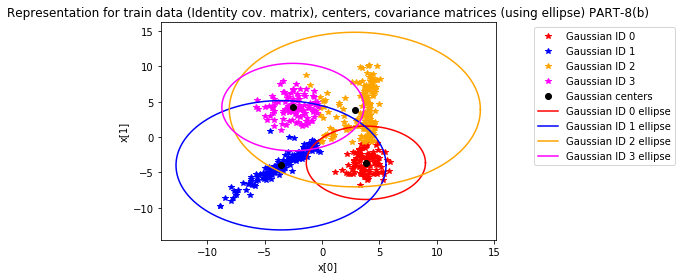

In [11]:
plt.figure()
plt.plot(cluster_0[:,0], cluster_0[:,1], '*', c='red',label='Gaussian ID 0')
plt.plot(cluster_1[:,0], cluster_1[:,1], '*', c='blue',label='Gaussian ID 1')
plt.plot(cluster_2[:,0], cluster_2[:,1], '*', c='orange',label='Gaussian ID 2')
plt.plot(cluster_3[:,0], cluster_3[:,1], '*', c='magenta',label='Gaussian ID 3')

plt.plot(cluster_0_mu[0],cluster_0_mu[1],'o',c='black',label='Gaussian centers')
plt.plot(cluster_1_mu[0],cluster_1_mu[1],'o',c='black')
plt.plot(cluster_2_mu[0],cluster_2_mu[1],'o',c='black')
plt.plot(cluster_3_mu[0],cluster_3_mu[1],'o',c='black')

plot_ellipse_cov(cluster_0_sigma_2*np.eye(cluster_0.shape[1]),cluster_0_mu, ax=plt, colour='red',label='Gaussian ID 0 ellipse')
plot_ellipse_cov(cluster_1_sigma_2*np.eye(cluster_1.shape[1]),cluster_1_mu, ax=plt, colour='blue',label='Gaussian ID 1 ellipse')
plot_ellipse_cov(cluster_2_sigma_2*np.eye(cluster_2.shape[1]),cluster_2_mu, ax=plt, colour='orange',label='Gaussian ID 2 ellipse')
plot_ellipse_cov(cluster_3_sigma_2*np.eye(cluster_3.shape[1]),cluster_3_mu, ax=plt, colour='magenta',label='Gaussian ID 3 ellipse')

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.title('Representation for train data (Identity cov. matrix), centers, covariance matrices (using ellipse) PART-8(b)')
plt.show()

In [12]:
mu_list = [cluster_0_mu, cluster_1_mu, cluster_2_mu, cluster_3_mu]
sigma_list = [cluster_0_sigma_2*np.eye(cluster_0.shape[1]), cluster_1_sigma_2*np.eye(cluster_1.shape[1]), cluster_2_sigma_2*np.eye(cluster_2.shape[1]), cluster_3_sigma_2*np.eye(cluster_3.shape[1])]
pi_list = [pi_0, pi_1, pi_2, pi_3]

train_avg_NLL = compute_NLL(train_data, mu_list, sigma_list, pi_list)
print 'Normalized log-likelihood for train data identity covariance matrix = %f' % train_avg_NLL

test_avg_NLL = compute_NLL(test_data, mu_list, sigma_list, pi_list)
print 'Normalized log-likelihood for test data identity covariance matrix = %f' % test_avg_NLL

Normalized log-likelihood for train data identity covariance matrix = -5.279893
Normalized log-likelihood for test data identity covariance matrix = -5.229809


In [13]:
# PART-C (EM with general matrix as covariance)

labels = k_means(data, n_clusters, n_iter)
    
cluster_0 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==0]).reshape(-1,2)
cluster_1 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==1]).reshape(-1,2)
cluster_2 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==2]).reshape(-1,2)
cluster_3 = np.asarray([data[j,:] for j in range(data.shape[0]) if labels[j,0]==3]).reshape(-1,2)

cluster_0_mu = np.mean(cluster_0,axis=0)
cluster_1_mu = np.mean(cluster_1,axis=0)
cluster_2_mu = np.mean(cluster_2,axis=0)
cluster_3_mu = np.mean(cluster_3,axis=0)

cluster_0_sigma = covariance(cluster_0)
cluster_1_sigma = covariance(cluster_1)
cluster_2_sigma = covariance(cluster_2)
cluster_3_sigma = covariance(cluster_3)

pi_0 = cluster_0.shape[0]*1.0/labels.shape[0]
pi_1 = cluster_1.shape[0]*1.0/labels.shape[0]
pi_2 = cluster_2.shape[0]*1.0/labels.shape[0]
pi_3 = cluster_3.shape[0]*1.0/labels.shape[0]

tau = np.zeros((data.shape[0],n_clusters))
n_iter = 20

for iter in range(n_iter):
    # E step
    for i in range(tau.shape[0]):
        tau[i,0] = pi_0*multivariate_normal.pdf(data[i,:], mean=cluster_0_mu, cov=cluster_0_sigma)
        tau[i,1] = pi_1*multivariate_normal.pdf(data[i,:], mean=cluster_1_mu, cov=cluster_1_sigma)
        tau[i,2] = pi_2*multivariate_normal.pdf(data[i,:], mean=cluster_2_mu, cov=cluster_2_sigma)
        tau[i,3] = pi_3*multivariate_normal.pdf(data[i,:], mean=cluster_3_mu, cov=cluster_3_sigma)
        
        norm_factor = np.sum(tau[i,:])
        tau[i,0] = tau[i,0]/norm_factor
        tau[i,1] = tau[i,1]/norm_factor
        tau[i,2] = tau[i,2]/norm_factor
        tau[i,3] = tau[i,3]/norm_factor
        
    # M step
    cluster_0_mu = np.sum(data*tau[:,0].reshape(-1,1),axis=0)/np.sum(tau[:,0])
    cluster_1_mu = np.sum(data*tau[:,1].reshape(-1,1),axis=0)/np.sum(tau[:,1])
    cluster_2_mu = np.sum(data*tau[:,2].reshape(-1,1),axis=0)/np.sum(tau[:,2])
    cluster_3_mu = np.sum(data*tau[:,3].reshape(-1,1),axis=0)/np.sum(tau[:,3])
    
    cluster_0_sigma = weighted_covariance(data, cluster_0_mu.reshape(1,-1), tau[:,0])
    cluster_1_sigma = weighted_covariance(data, cluster_1_mu.reshape(1,-1), tau[:,1])
    cluster_2_sigma = weighted_covariance(data, cluster_2_mu.reshape(1,-1), tau[:,2])
    cluster_3_sigma = weighted_covariance(data, cluster_3_mu.reshape(1,-1), tau[:,3])
    
    pi_0 = np.sum(tau[:,0])/data.shape[0]
    pi_1 = np.sum(tau[:,1])/data.shape[0]
    pi_2 = np.sum(tau[:,2])/data.shape[0]
    pi_3 = np.sum(tau[:,3])/data.shape[0]
    
cluster_0 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==0]).reshape(-1,2)
cluster_1 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==1]).reshape(-1,2)
cluster_2 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==2]).reshape(-1,2)
cluster_3 = np.asarray([data[j,:] for j in range(data.shape[0]) if np.argmax(tau[j,:])==3]).reshape(-1,2)

In [14]:
print 'mean vector for Gaussian ID: 0'
print cluster_0_mu
print 'covariance matrix for Gaussian ID: 0'
print cluster_0_sigma
print 'mean vector for Gaussian ID: 1'
print cluster_1_mu
print 'covariance matrix for Gaussian ID: 1'
print cluster_1_sigma
print 'mean vector for Gaussian ID: 2'
print cluster_2_mu
print 'covariance matrix for Gaussian ID: 2'
print cluster_2_sigma
print 'mean vector for Gaussian ID: 3'
print cluster_3_mu
print 'covariance matrix for Gaussian ID: 3'
print cluster_3_sigma

mean vector for Gaussian ID: 0
[-2.03403251  4.17292588]
covariance matrix for Gaussian ID: 0
[[ 2.90593799  0.20797413]
 [ 0.20797413  2.75677474]]
mean vector for Gaussian ID: 1
[-3.05955957 -3.53227745]
covariance matrix for Gaussian ID: 1
[[ 6.25358436  6.06156956]
 [ 6.06156956  6.19309792]]
mean vector for Gaussian ID: 2
[ 3.79949892 -3.77435669]
covariance matrix for Gaussian ID: 2
[[ 0.91157737  0.05563614]
 [ 0.05563614  1.91377122]]
mean vector for Gaussian ID: 3
[ 3.98128623  3.84140688]
covariance matrix for Gaussian ID: 3
[[  0.20833648   0.27535685]
 [  0.27535685  11.93301111]]


C:\Users\Vardaan123\Anaconda2\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


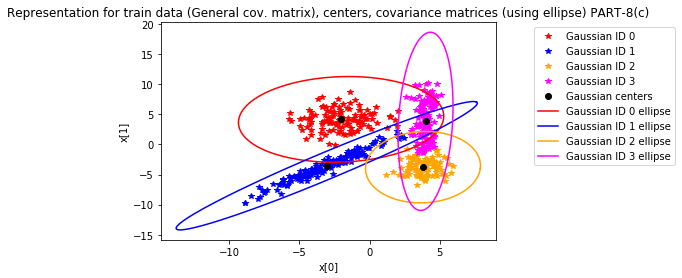

In [15]:
plt.figure()
plt.plot(cluster_0[:,0], cluster_0[:,1], '*', c='red',label='Gaussian ID 0')
plt.plot(cluster_1[:,0], cluster_1[:,1], '*', c='blue',label='Gaussian ID 1')
plt.plot(cluster_2[:,0], cluster_2[:,1], '*', c='orange',label='Gaussian ID 2')
plt.plot(cluster_3[:,0], cluster_3[:,1], '*', c='magenta',label='Gaussian ID 3')

plt.plot(cluster_0_mu[0],cluster_0_mu[1],'o',c='black',label='Gaussian centers')
plt.plot(cluster_1_mu[0],cluster_1_mu[1],'o',c='black')
plt.plot(cluster_2_mu[0],cluster_2_mu[1],'o',c='black')
plt.plot(cluster_3_mu[0],cluster_3_mu[1],'o',c='black')

plot_ellipse_cov(cluster_0_sigma,cluster_0_mu, ax=plt, colour='red',label='Gaussian ID 0 ellipse')
plot_ellipse_cov(cluster_1_sigma,cluster_1_mu, ax=plt, colour='blue',label='Gaussian ID 1 ellipse')
plot_ellipse_cov(cluster_2_sigma,cluster_2_mu, ax=plt, colour='orange',label='Gaussian ID 2 ellipse')
plot_ellipse_cov(cluster_3_sigma,cluster_3_mu, ax=plt, colour='magenta',label='Gaussian ID 3 ellipse')

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.title('Representation for train data (General cov. matrix), centers, covariance matrices (using ellipse) PART-8(c)')
plt.show()

In [16]:
mu_list = [cluster_0_mu, cluster_1_mu, cluster_2_mu, cluster_3_mu]
sigma_list = [cluster_0_sigma, cluster_1_sigma, cluster_2_sigma, cluster_3_sigma]
pi_list = [pi_0, pi_1, pi_2, pi_3]

train_avg_NLL = compute_NLL(train_data, mu_list, sigma_list, pi_list)
print 'Normalized log-likelihood for train data general covariance matrix = %f' % train_avg_NLL

test_avg_NLL = compute_NLL(test_data, mu_list, sigma_list, pi_list)
print 'Normalized log-likelihood for test data general covariance matrix = %f' % test_avg_NLL

Normalized log-likelihood for train data general covariance matrix = -4.655464
Normalized log-likelihood for test data general covariance matrix = -4.818412
